# Project

### 1 Load Packages

In [1]:
# ========================TensorFlow========================
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0-rc2


In [2]:
# ========================General========================
import os
import io
import sys
import time
import json
import joblib
import pandas as pd
import numpy as np
import requests
import statistics
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# ========================Ploting========================
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# ========================Data Preprocessing========================
from sklearn import preprocessing
# Encoding
from sklearn.preprocessing import LabelEncoder
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Data Split
from sklearn.model_selection import train_test_split
# ========================Modeling========================
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree & Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# KMeans
from sklearn.cluster import KMeans
# ========================Evaluation========================
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
# ========================Deep Learning========================
# MLP
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
# ================================================

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2 Load dataset

In [0]:
# load movie
def load_tmdb_movies(path):
    # df = pd.read_csv(path)
    # df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    df = pd.read_csv(path)
    df = df[df.release_date.notnull()]
    df = df[df.release_date.str.contains("^\d{4}\-\d{2}.")]
    df = df[df.release_date>="1970-01-01"]
    df['release_year'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.year) if x==x else None)
    df['release_month'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.month) if x==x else None)
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# load movie credits
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# Columns that existed in IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [0]:
# movies_url = 'https://drive.google.com/file/d/19C8m6CwRu9I-eydnTbp4gPCp_eeFMb7t'
# credits_url = "https://drive.google.com/file/d/1mnH9UaaXZ-gP3At0Q2Qus-Gz0EJOqiYx"
# movies_content = requests.get(movies_url).content
# credits_content = requests.get(credits_url).content

In [0]:
movies_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_data.csv'
credits_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_credits.csv'

In [0]:
movies = load_tmdb_movies(movies_path)
credits = load_tmdb_credits(credits_path)
raw_data =convert_to_original_format(movies, credits)

### 3 Data Preprocessing
*   Handling Missing Values
*   Drop Duplication Values
*   Drop Outliers

#### 3.1 Handling Missing Values

In [10]:
raw_data.head(1)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,release_year,release_month,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
3,0,Comedy,NaN,21624,,NaN,Jatts in Golmaal,Jatts in Golmal is an Comedy based movie. In w...,0.6,[],[],2003-02-21,0.0,NaN,[],Released,NaN,Jatts in Golmaal,0.0,0.0,2003,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
total_missing = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/len(raw_data)).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent], axis=1, keys=['total Missing', 'Percent'])
missing_data.head(11)

,total Missing,Percent
homepage,36258,0.841800
companies_3,35398,0.821833
actor_3_name,29391,0.682369
actor_2_name,29179,0.677447
director_name,29042,0.674266
companies_2,28811,0.668903
actor_1_name,28747,0.667417
tagline,27682,0.642691
companies_1,16102,0.373839
country,8171,0.189706


In [0]:
# drop homepage & tagline
raw_data.drop(['homepage','tagline'], axis=1, inplace=True)

#### 3.2 Drop Duplication Values and Unseen Features

In [0]:
# Drop Duplication Values
drop_duplicates_subset = ('budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title','overview', 'popularity','release_date', 'gross', 'duration','status','movie_title','vote_average','num_voted_users')
raw_data.drop_duplicates(subset=drop_duplicates_subset, keep='first', inplace=True)

In [0]:
# Drop features that only know after movie release
raw_data.drop(['num_voted_users', 'gross', 'popularity'], axis=1, inplace=True)

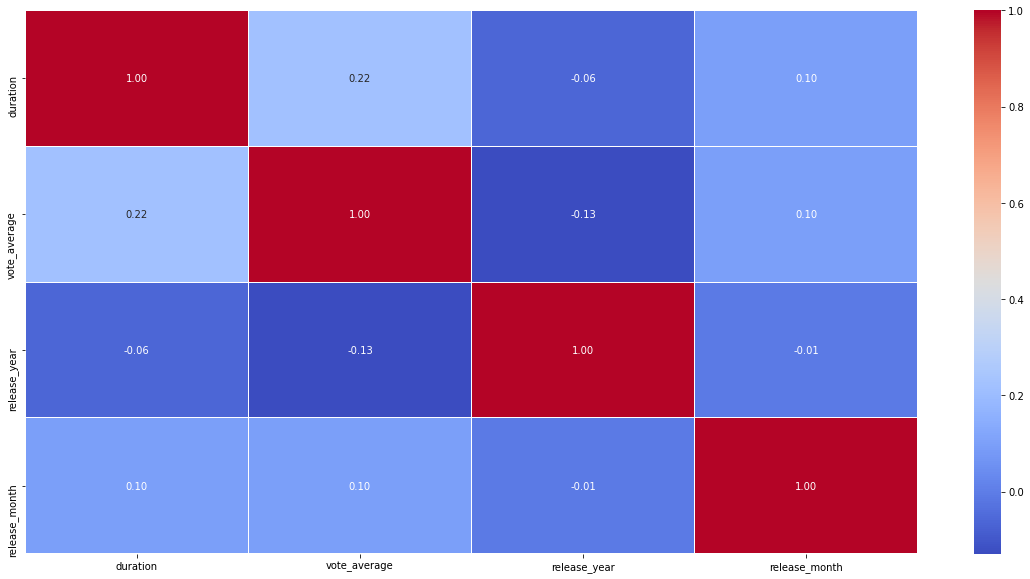

In [15]:
# Correlation matrix between numerical values
plt.figure(figsize = (20,10))
g = sns.heatmap(raw_data[list(raw_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

#### 3.3 Drop Outliers

<Figure size 1080x720 with 0 Axes>

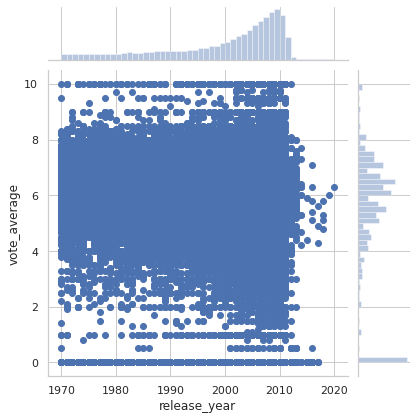

In [16]:
# release_year and vote_average
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.jointplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

In [17]:
# Drop rows in dataset containing 0 and below vote average
before_rows = len(raw_data)
raw_data = raw_data[raw_data['vote_average'] > 0]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 4915 rows;
Current Total rows: 38157


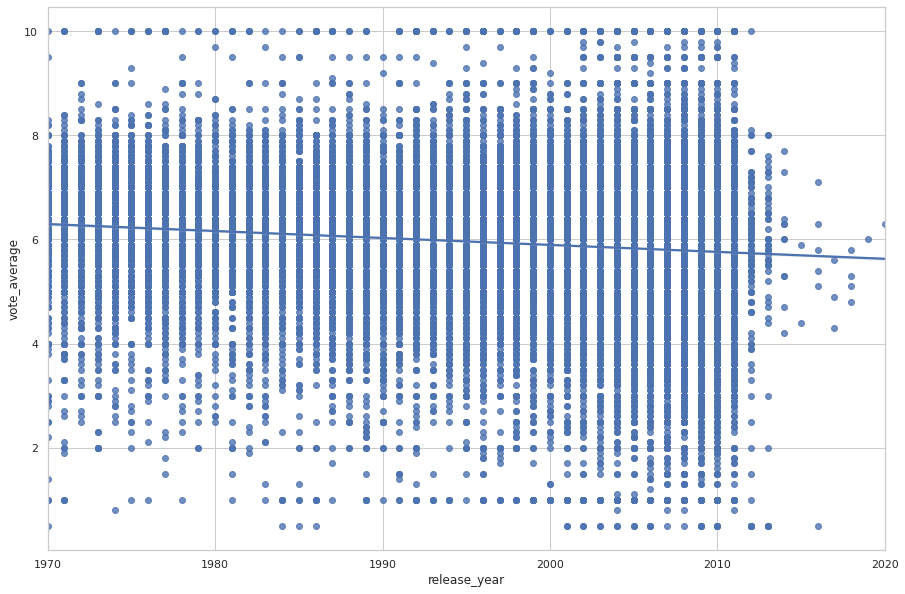

In [18]:
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.regplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

<Figure size 1080x720 with 0 Axes>

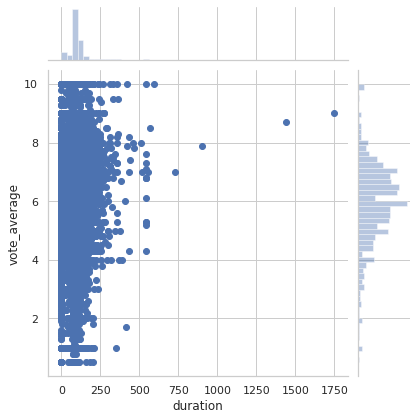

In [19]:
# Duration and vote_average
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.jointplot(x="duration", y="vote_average", data=raw_data)
plt.show()

In [20]:
# Most of directors decide to make 90-120 mins movie, 0-10 duration is unlikely possible
# Drop rows in dataset of which duration > 10 and duration < 600
before_rows = len(raw_data)
raw_data = raw_data[10<raw_data['duration']]
raw_data = raw_data[raw_data['duration']<600]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 2537 rows;
Current Total rows: 35620


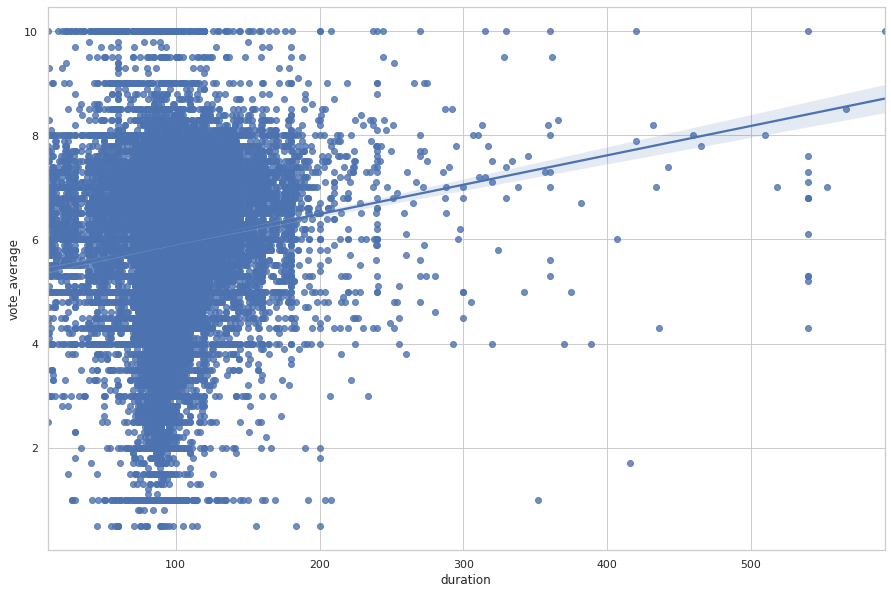

In [21]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.regplot(x="duration", y="vote_average", data=raw_data)
plt.show()

### 4 Data Wrangling: Define a movie is successful or unsuccessful and edit features
*   Define Label
*   Budget
*   Release Year
*   Duration
*   Genres
*   Director
*   Actor
*   Company

#### 4.1 Define Label

In [22]:
# Total columns fot dataset
raw_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'duration', 'spoken_languages', 'status', 'movie_title',
       'vote_average', 'release_year', 'release_month', 'country',
       'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
       'companies_1', 'companies_2', 'companies_3'],
      dtype='object')

In [23]:
raw_data.describe(percentiles=[.10,.25,.5,.75,.9,.99], include=['float','int'])

,duration,vote_average,release_year,release_month
count,35620.000000,35620.000000,35620.000000,35620.000000
mean,98.605334,5.914486,1998.545705,6.293964
std,29.789989,1.370758,11.226824,3.702256
min,11.000000,0.500000,1970.000000,1.000000
10%,75.000000,4.100000,1980.000000,1.000000
25%,87.000000,5.200000,1992.000000,3.000000
50%,95.000000,6.000000,2003.000000,6.000000
75%,107.000000,6.800000,2007.000000,10.000000
90%,125.000000,7.400000,2010.000000,11.000000
99%,189.000000,9.300000,2011.000000,12.000000


In [24]:
# For this kernel, successful movies is a movie which got vote_score more than vote_score mean
raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s >= raw_data['vote_average'].mean() else 0)
raw_data.success.value_counts()

1    19547
0    16073
Name: success, dtype: int64

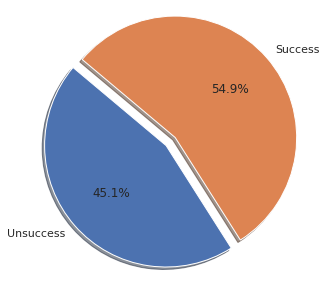

In [25]:
# Data to plot
plt.figure(figsize=(5,5))
labels = ["Unsuccess","Success"]
sizes = raw_data['success'].value_counts(sort=False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

#### 4.2 Budget

In [0]:
raw_data.budget=raw_data.budget.astype(int)

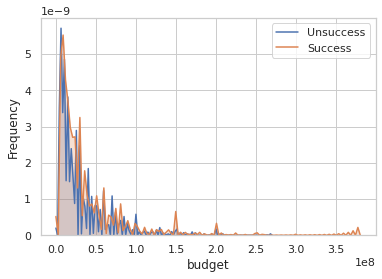

In [27]:
# budget distibution
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

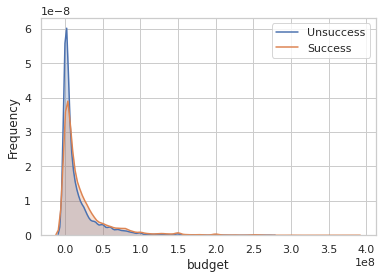

In [28]:
# Non-zero budget distibution
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 0)], shade = True)
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 1)], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

In [0]:
# The Q1,Q2(median),Q3,95% of budget of non-zero movies
non_zero_budget_Q1 = raw_data.budget[raw_data.budget>0].quantile(0.25)
non_zero_budget_median = raw_data.budget[raw_data.budget>0].quantile(0.5)
non_zero_budget_Q3 = raw_data.budget[raw_data.budget>0].quantile(0.75)
non_zero_budget_95 = raw_data.budget[raw_data.budget>0].quantile(0.95)

In [0]:
# Create new feature of budget 
raw_data['VeryLowBudget'] = raw_data['budget'].map(lambda s: 1 if s < non_zero_budget_Q1 else 0)
raw_data['LowBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q1 <= s < non_zero_budget_median else 0)
raw_data['MedBudget'] = raw_data['budget'].map(lambda s: 1 if  non_zero_budget_median <= s < non_zero_budget_Q3 else 0)
raw_data['HighBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q3 <= s < non_zero_budget_95 else 0)
raw_data['VeryHighBudget'] = raw_data['budget'].map(lambda s: 1 if s >= non_zero_budget_95 else 0)

#### 4.3 Release Year

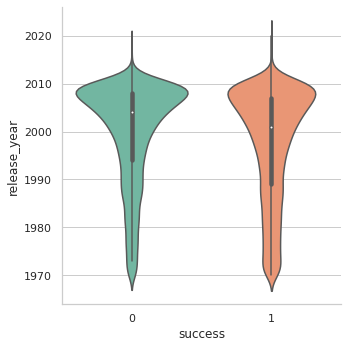

In [31]:
# Release Year Distribution
g = sns.factorplot(y="release_year",x="success",data=raw_data,kind="violin", palette = "Set2")

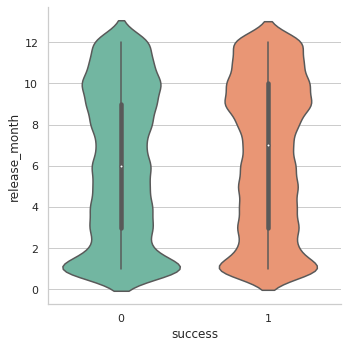

In [32]:
# Release Month Distribution
g = sns.factorplot(y="release_month",x="success",data=raw_data,kind="violin", palette = "Set2")

#### 4.4 Duration

In [33]:
before = len(raw_data)
raw_data = raw_data[np.isfinite(raw_data['duration'])]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before-len(raw_data), len(raw_data)))

Delete 0 rows;
Current Total rows: 35620


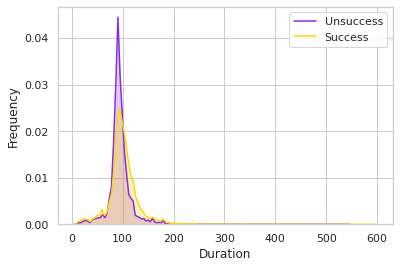

In [34]:
# duration distibution
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

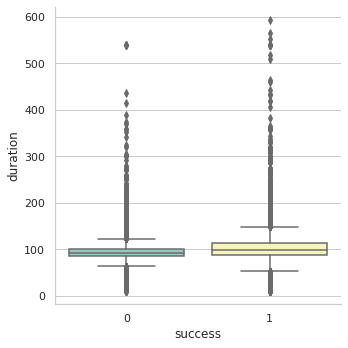

In [35]:
# duration distibution by success
g = sns.factorplot(x="success", y = "duration",data = raw_data, kind="box", palette = "Set3")

In [0]:
'''
Based on common sence
duration <90          => Short Movie
90 <= duration < 120  => Normal Movie
120 <= duration       => Long Movie
'''
raw_data['ShortMovie'] = raw_data['duration'].map(lambda s: 1 if s < 90 else 0)
raw_data['NormalMovie'] = raw_data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
raw_data['LongMovie'] = raw_data['duration'].map(lambda s: 1 if s >= 120 else 0)

#### 4.5 Genres
Since a movie may have multiple genres, we will use one-hot encoding to transform the column of Genres

In [37]:
raw_data.genres.head()

4                         
6       Drama|Crime|Comedy
7             Drama|Comedy
8             Crime|Comedy
9    Action|Thriller|Crime
Name: genres, dtype: object

In [0]:
def Obtain_list_Occurences(data, column):
    # Obtaining list of column
    listOcc = []
    for i in data[column]:
        split_genre = list(map(str, i.split('|')))
        for j in split_genre:
            if j not in listOcc:
                listOcc.append(j)
    return listOcc

In [0]:
genre = []
genre = Obtain_list_Occurences(raw_data, "genres")
# Drop empty string
genre = list(filter(lambda x:len(x)>0, genre))

In [0]:
# Encoding genre
for w in genre:
    raw_data[w] = raw_data['genres'].map(lambda s: 1 if w in str(s) else 0)

In [41]:
raw_data.loc[:,genre].head()

,Drama,Crime,Comedy,Action,Thriller,Documentary,Adventure,Science Fiction,Animation,Family,Romance,Horror,Mystery,Fantasy,War,Music,History,Western,TV Movie
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 4.6 Director

In [0]:
raw_data.director_name.fillna('unknown', inplace=True)

In [0]:
def to_frequency_table(data):
    frequency = {}
    for key in data:
        if key in frequency and key:
            frequency[key] += 1
        else:
            frequency[key] = 1
    return frequency

In [0]:
director_dic = to_frequency_table(raw_data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
director_list=list(filter(lambda x:x[0]!='unknown', director_list))

In [0]:
# Funtion to find top xx in list
def Top(List, top_num):
    Top = list()
    for i in range(0, top_num):
        Top.append(List[i][0])
    return Top

In [46]:
# Encoding Top 50 director
for w in Top(director_list, 50):
    raw_data[w] = raw_data['director_name'].map(lambda s: 1 if w in str(s) else 0)
# Encoding non-Top 50 director in 'other_director' columns
raw_data['other_director'] = raw_data['director_name'].map(lambda x:1 if x not in Top(director_list, 50) else 0)
print("Total movies of top directors: {};\nTotal movies of non-top directors: {};\nTotal movies: {}.".format(raw_data[Top(director_list, 50)].sum().sum(), raw_data.other_director.sum(), len(raw_data)))

Total movies of top directors: 828;
Total movies of non-top directors: 34792;
Total movies: 35620.


#### 4.7 Actor

In [0]:
# Fill none value in 3 actor columns
raw_data.actor_1_name.fillna('unknown',inplace=True)
raw_data.actor_2_name.fillna('unknown',inplace=True)
raw_data.actor_3_name.fillna('unknown',inplace=True)

In [48]:
raw_data[['actor_1_name','actor_2_name','actor_3_name']]

,actor_1_name,actor_2_name,actor_3_name
4,Darren Berrecloth,Cameron McCaul,Paul Basagoitia
6,Turo Pajala,Susanna Haavisto,Matti Pellonpää
7,Matti Pellonpää,Kati Outinen,Sakari Kuosmanen
8,Tim Roth,Sammi Davis,Amanda de Cadenet
9,Emilio Estevez,Cuba Gooding Jr.,Denis Leary
...,...,...,...
1934370,unknown,unknown,unknown
1934371,unknown,unknown,unknown
1934372,unknown,unknown,unknown
1934373,unknown,unknown,unknown


In [0]:
# # Combine 3 columns and sort the occurrence
# raw_data['actors_name'] = raw_data[['actor_1_name','actor_2_name','actor_3_name']].apply(lambda x:'|'.join(x), axis=1)
# actor_occ = []
# actor_occ = Obtain_list_Occurences(raw_data,"actors_name")
# # Drop 'unknown' string
# actor_occ = list(filter(lambda x:x!='unknown', actor_occ))

In [0]:
# actor_dic = to_frequency_table(actor_occ)
# actor_list = list(actor_dic.items())
# actor_list.sort(key=lambda tup:tup[1],reverse=True)
# # drop 'unknown' item
# actor_list=list(filter(lambda x:x[0]!='unknown', actor_list))

In [0]:
# Encoding actor column
# for w in actor_occ:
#     raw_data[w] = raw_data['actors_name'].map(lambda s: 1 if w in str(s) else 0)

#### 4.8 Company

In [0]:
# Fill none value in 3 actor columns
raw_data['companies_1'].fillna('unknown',inplace=True)
raw_data['companies_2'].fillna('unknown',inplace=True)
raw_data['companies_3'].fillna('unknown',inplace=True)

In [0]:
company_dic = to_frequency_table(raw_data['companies_1'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_1=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_2=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_3=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
# Combine all company in one list
full_company_list=sorted(company_list_1+company_list_2+company_list_3)
company_dict={}
for a,b in full_company_list:
    if a not in company_dict.keys():
        company_dict[a] = b
    elif a in company_dict.keys():
        company_dict[a] = company_dict.get(a) + b

combined_company_list = list(company_dict.items())
combined_company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
combined_company_list=list(filter(lambda x:x[0]!='unknown', combined_company_list))

In [57]:
total=0
for a,b in combined_company_list:
    total += b

top_index = 0
top_count = 0
for a,b in combined_company_list:
    if b >= 20:
        top_count += b
        top_index += 1
    else:
        break
print(top_index)
print(len(combined_company_list))
print(combined_company_list[top_index])

295
14867
('Amicus Productions', 19)


In [0]:
# Create company columns
toplist = Top(combined_company_list, top_index)
for w in toplist:
    raw_data[w] = 0

In [0]:
# Encoding Top company
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_1'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_2'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_3'].map(lambda x: 1 if x in w else 0)

In [60]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35620 entries, 4 to 1934374
Columns: 399 entries, budget to Winkler Films
dtypes: float64(2), int64(377), object(20)
memory usage: 110.0+ MB


#### 4.9 Drop Columns

In [0]:
raw_data.drop(['budget','genres','id','plot_keywords','language','original_title','overview',
               'production_companies','production_countries','release_date','duration','spoken_languages','status','movie_title','vote_average','country',
               'director_name','actor_1_name','actor_2_name',
               'actor_3_name','companies_1','companies_2','companies_3'], axis=1, inplace=True)

In [62]:
# Check missing value
total = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/raw_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Winkler Films,0,0.0
American International Pictures,0,0.0
HBO,0,0.0
Orange Sky Golden Harvest,0,0.0
Zentropa Entertainments,0,0.0


### 5 Modeling
*   Define Useful Functions
*   Split Data
*   K-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   Conclusion Model Performance
*   Model Test

#### 5.0 Define Useful Functions

In [0]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def model_selection(clf, x_train_all, y_train_all, x_train, y_train, x_test, y_test):
    clf.fit(x_train,y_train)
    score_all=cross_val_score(clf, x_train_all, y_train_all, cv=5)
    avg_score=score_all.mean()
    print("Accuracy Score for 5-fold Cross Validation: {}".format(round(avg_score,2)))
    y_test_pred=clf.predict(x_test)
    cm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm, normalize = False, target_names = ['failed','success'],title = "Confusion Matrix over Test Data")

#### 5.1 Split Data

In [0]:
# Split data into train and test set
data = raw_data
y = data['success']
y = np.array(y).reshape(-1,1)
x = data.drop('success',axis=1)

In [0]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,random_state=10, test_size=.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11, test_size=0.25)

In [67]:
print('x_train: {}; y_train: {}.'.format(x_train.shape, y_train.shape))
print('x_valid: {}; y_valid: {}.'.format(x_valid.shape, y_valid.shape))
print('x_test: {}; y_test: {}.'.format(x_test.shape, y_test.shape))

x_train: (20036, 375); y_train: (20036, 1).
x_valid: (6679, 375); y_valid: (6679, 1).
x_test: (8905, 375); y_test: (8905, 1).


#### 5.2 K-Nearest Neighbors

In [68]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

Accuracy Score for 5-fold Cross Validation: 0.61


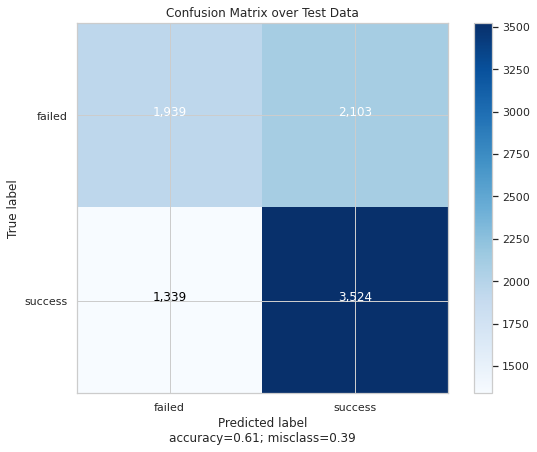

In [69]:
model_selection(knn, x_train_all, y_train_all, x_train, y_train, x_test, y_test)

#### 5.3 Decision Tree

In [70]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=10)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy Score for 5-fold Cross Validation: 0.62


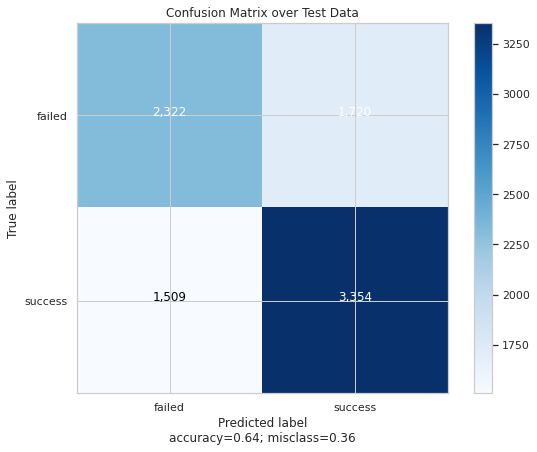

In [71]:
model_selection(decision_tree, x_train_all, y_train_all, x_train, y_train, x_test, y_test)